In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures,MinMaxScaler,StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error,classification_report,roc_auc_score,roc_curve
from sklearn.model_selection import learning_curve, validation_curve
from scipy.stats import randint,zscore,skew,kurtosis
from sklearn.metrics import r2_score
from sklearn.decomposition import PCA

### Import Data

In [2]:
def tokenize(name_string, only_noun=True):
    w_pair = pseg.cut(str(name_string))
    tokens = [(word, tag) for word, tag in w_pair]
    if only_noun:
            tokens = [wt[0] for wt in tokens if wt[1].startswith('n')]
    return tokens

In [3]:
def process_names(name):
    return ''.join([i for i in name if i.isalpha()])

In [4]:
def build_vocab(names, min_freq=10):
    vocab = {}
    for tokens in names:
        for t in tokens:
            if t in vocab:
                vocab[t] += 1
            else:
                vocab[t] = 1

    keys = list(vocab.keys())

    for k in keys:
        if len(k) < 2:
            del vocab[k]

        if k in vocab:
            if vocab[k] < min_freq:
                del [vocab[k]]
                
    return vocab

In [8]:
def get_price(row, token_price_dict):
    price_list = [token_price_dict[t] for t in row if t in token_price_dict]
    if len(price_list) == 0:
        return 0
    else:
        return sum(price_list) / len(price_list)

In [5]:
def build_price_dict(df, vocab):
    price_dict = {}
    for index, row in df.iterrows():
        for t in row['name']:
            if t in vocab:
                price_dict[t] = price_dict.get(t, 0) + row['price']
                
    return price_dict

In [1]:
def data_import():
    df_dish = pd.read_csv('../data/dish_info.csv')
    print('Orginal size of the dataset is {}'.format(len(df_dish)))
    print('Processing dataset..')

    df_dish1 = df_dish[(df_dish['price'] > 0) & (df_dish['price'] < 100)]
    df_dish1['name'] = df_dish1['name'].apply(process_names)
    df_dish1 = df_dish1[pd.notnull(df_dish1['name'])]
    df_dish1 = df_dish1[df_dish1['name'].str.len() != 0]
    df_dish1 = df_dish1[~df_dish1['name'].str.isnumeric()]
    print('After processing, the size of the dataset is {}'.format(len(df_dish1)))
    print('Merging with order dataset..')
    
    df_order = pd.read_csv('../data/OrderAprtoJun.csv')
    kitchen_orders = df_order.groupby('kitchen_id').size().reset_index(name='kitchen_orders')
    df_dish2 = pd.merge(df_dish1, kitchen_orders, on='kitchen_id', how='left')

    # kitchen location included
    df_kitchen = pd.read_csv('../data/kitchen_info.csv')
    df_dish3 = pd.merge(df_dish2, df_kitchen[['kitchen_id', 'city_id']], on='kitchen_id', how='left')
    
    # if 'kitchen_id' and 'name' included    
    df_dish3 = df_dish2.drop(columns =['index','dish_id','tags','description','check_time','refusal_ground','create_time',\
                                   'update_time','speech_time','dish_feature','materials','net_price'], axis=1).fillna(0)
    print('Done!')
    return df_dish3

In [34]:
def kitchen_median(df):
    return df.groupby('kitchen_id')['price'].median().reset_index().rename(columns={'price': 'kitchen_median'})

In [35]:
def dish_median(df):
    return df.groupby('name')['price'].median().reset_index().rename(columns={'price': 'dish_median'})

### Setup Models

In [170]:
def split_data(df):
    print('Spliting the dataset into train(80%) and test(20%)')
    train, test = train_test_split(df, test_size=0.2, random_state=5)
    m = train.price.median()
    
    # adding kitchen_mean, dish_mean
    df_price = kitchen_median(train)
    df_dish_price = dish_median(train)
    
    X_train = pd.merge(train, df_price, on='kitchen_id', how='left')
    X_train = pd.merge(X_train, df_dish_price, on='name', how='left')
    
    X_train = X_train.drop(['kitchen_id'], axis=1)
    X_train = X_train.drop(['name'], axis=1)
    
#     X_train.head()
    
    X_train['dish_median'].fillna(m, inplace=True)
    X_train['kitchen_median'].fillna(m, inplace=True)
    # adding kitchen_mean
    
    X_train = X_train.drop(['price'], axis=1)
    
    y_train = train['price']
    
    # adding kitchen_mean
    X_test = pd.merge(test, df_price, on='kitchen_id', how='left')
    X_test = pd.merge(X_test, df_dish_price, on='name', how='left')
    X_test = X_test.drop(['kitchen_id'], axis=1)
    X_test = X_test.drop(['name'], axis=1)
    
    X_test['dish_median'].fillna(m, inplace=True)
    X_test['kitchen_median'].fillna(m, inplace=True)
    # adding kitchen_mean
    
    X_test = X_test.drop(['price'], axis=1)
    
    y_test = test['price'] 
    print('Train size: {}'.format(len(X_train)))
    print('Test size: {}'.format(len(X_test)))
    return X_train, y_train, X_test, y_test

In [33]:
def evaluation(x,y,model):
    price_predictions = model.predict(x)
    mse = mean_squared_error(y, price_predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y, price_predictions)
    r2 = r2_score(y, price_predictions)
    return 'RMSE:{}'.format(rmse), 'MAE:{}'.format(mae),'R-square:{}'.format(r2)

In [32]:
import time

start = time.time()
def fit_model(X_train,y_train, X_test, y_test):
    print('Fitting model..')
    forest_reg = RandomForestRegressor(random_state=3,max_features=12, n_estimators=100,max_depth=10).fit(X_train, y_train)
    print('Took {} seconds to train the model'.format(round(time.time() - start, 2)))
    
    forest_reg.fit(X_train, y_train)
    print('in-sample evaluation:{}'.format(evaluation(X_train, y_train, forest_reg)))
    
    print('')
    forest_reg.fit(X_test, y_test)
    print('out-sample evaluation:{}'.format(evaluation(X_test, y_test, forest_reg)))
    

In [175]:
df_dish = data_import()
X_train, y_train, X_test, y_test = split_data(df_dish)

Orginal size of the dataset is 382941
Processing dataset..
After processing, the size of the dataset is 380041
Merging with order dataset..
Done!
Spliting the dataset into train(80%) and test(20%)
Train size: 304032
Test size: 76009


### original

In [63]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 77.99 seconds
in-sample evaluation:('RMSE:9.112406431468235', 'MAE:6.029471329671213', 'R-square:0.21702755069399426')

out-sample evaluation:('RMSE:8.877321879739693', 'MAE:5.9388763387042545', 'R-square:0.25476089947121305')


### with kitchen_median

In [116]:
fit_model(X_train, y_train, X_test, y_test)

Fitting model..
Took 472.4 seconds to train the model
in-sample evaluation:('RMSE:8.191574519474177', 'MAE:5.356326475790847', 'R-square:0.3672748612529624')

out-sample evaluation:('RMSE:8.271708214654385', 'MAE:5.5588714045276975', 'R-square:0.35297343591554386')


### with dish_median

In [148]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 91.91 seconds to train the model
in-sample evaluation:('RMSE:3.7192829335998665', 'MAE:1.9399541272073666', 'R-square:0.8695636157522533')

out-sample evaluation:('RMSE:7.025540427152184', 'MAE:4.216528172430425', 'R-square:0.5332426417375431')


### test with another random_state

In [166]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 109.21 seconds to train the model
in-sample evaluation:('RMSE:3.7311068761611415', 'MAE:1.946002461047007', 'R-square:0.8692713417092959')

out-sample evaluation:('RMSE:6.899004533650003', 'MAE:4.15771996554241', 'R-square:0.542333685602073')


### adding location

In [176]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 248.95 seconds to train the model
in-sample evaluation:('RMSE:3.7311068761611415', 'MAE:1.946002461047007', 'R-square:0.8692713417092959')

out-sample evaluation:('RMSE:6.899004533650003', 'MAE:4.15771996554241', 'R-square:0.542333685602073')


### using tokens mean

In [47]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 65.03 seconds to train the model
in-sample evaluation:('RMSE:6.4582977492979', 'MAE:3.9571096460430843', 'R-square:0.6059240732025206')

out-sample evaluation:('RMSE:6.456177272357769', 'MAE:4.0261079114730505', 'R-square:0.6089446288590019')


In [18]:
def data_import():
    df_dish = pd.read_csv('../data/dish_info.csv')
    print('Orginal size of the dataset is {}'.format(len(df_dish)))
    print('Processing dataset..')

    df_dish = df_dish[(df_dish['price'] > 0) & (df_dish['price'] < 100)]
#     df_dish.drop('index', inplace=True,axis=1)
    
    # get rid of outliers
    df_dish = df_dish[pd.notnull(df_dish['name'])]
    df_dish = df_dish[df_dish['price'] <= 100]
    
    # get rid of invalid names
    df_dish['name'] = df_dish['name'].apply(process_names)
    df_dish = df_dish[df_dish['name'].str.len() != 0]
    df_dish = df_dish[~df_dish['name'].str.isnumeric()]
    print('After processing, the size of the dataset is {}'.format(len(df_dish)))
    print('Merging with order dataset..')
    
    df_order = pd.read_csv('../data/OrderAprtoJun.csv')
    kitchen_orders = df_order.groupby('kitchen_id').size().reset_index(name='kitchen_orders')
    df_dish2 = pd.merge(df_dish, kitchen_orders, on='kitchen_id', how='left')

    # kitchen location included
    df_kitchen = pd.read_csv('../data/kitchen_info.csv')
    df_dish3 = pd.merge(df_dish2, df_kitchen[['kitchen_id', 'city_id']], on='kitchen_id', how='left')
    
    # if 'kitchen_id' and 'name' included    
    df_dish3 = df_dish2.drop(columns =['index','dish_id','tags','description','check_time','refusal_ground','create_time',\
                                   'update_time','speech_time','dish_feature','materials','net_price'], axis=1).fillna(0)
    print('Done!')
    return df_dish3

In [29]:
def split_data_with_token_mean(df):
    # tokenize the names of the dishes
    start = time.time()
    df['name'] = df['name'].apply(tokenize)
    print('used {:0.2f} seconds to tokenize the names'.format(time.time() - start))
    
    # split the dataframe into training and testing
    train, test = train_test_split(df, test_size=0.2, random_state=0)
    
    # build vocab using the dish names in train
    names = list(train['name'])
    vocab = build_vocab(names, min_freq=5)
    
    # get the summation of price for all tokens
    start = time.time()
    price = build_price_dict(train, vocab)
    print('used {:0.2f} seconds to get tokens prices'.format(time.time() - start))
    
    # build reference dataframe
    df_outcome = pd.DataFrame({'name':list(vocab.keys()), 'count': list(vocab.values()), 'price_sum':list(price.values())})
    df_outcome['mean_price'] = df_outcome['price_sum'] / df_outcome['count']
    
    token_price_dict = dict(zip(df_outcome.name, df_outcome.mean_price))
    m = train.price.median()
    
    train['tokens_mean'] = train['name'].apply(lambda x: (get_price(x, token_price_dict)))
    test['tokens_mean'] = test['name'].apply(lambda x: (get_price(x, token_price_dict)))
    test['tokens_mean'].fillna('')
    
    # adding kitchen_mean, dish_mean
    df_price = kitchen_median(train)
#     df_dish_price = dish_median(train)
    df_dish_price = df_outcome[['kithen_id', 'mean_']]
    
    X_train = pd.merge(train, df_price, on='kitchen_id', how='left')
    X_train = pd.merge(X_train, df_dish_price, on='name', how='left')
    
    X_train = X_train.drop(['kitchen_id'], axis=1)
    X_train = X_train.drop(['name'], axis=1)
    
#     X_train.head()
    
    X_train['kitchen_median'].fillna(m, inplace=True)
    # adding kitchen_mean
    
    X_train = X_train.drop(['price'], axis=1)
    
    y_train = train['price']
    
    # adding kitchen_mean
    X_test = pd.merge(test, df_price, on='kitchen_id', how='left')
    X_test = pd.merge(X_test, df_dish_price, on='name', how='left')
    X_test = X_test.drop(['kitchen_id'], axis=1)
    X_test = X_test.drop(['name'], axis=1)
    
    X_test['kitchen_median'].fillna(m, inplace=True)
    # adding kitchen_mean
    
    X_test = X_test.drop(['price'], axis=1)
    
    y_test = test['price'] 
    print('Train size: {}'.format(len(X_train)))
    print('Test size: {}'.format(len(X_test)))
    return X_train, y_train, X_test, y_test

In [25]:
import time
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [26]:
import pandas as pd
import numpy as np

In [27]:
import jieba
import jieba.posseg as pseg

In [24]:
df_dish = data_import()
# X_train, y_train, X_test, y_test = split_data(df_dish)

Orginal size of the dataset is 382941
Processing dataset..
After processing, the size of the dataset is 380041
Merging with order dataset..
Done!


In [46]:
df = df_dish

# tokenize the names of the dishes
start = time.time()
df['name'] = df['name'].apply(tokenize)
print('used {:0.2f} seconds to tokenize the names'.format(time.time() - start))

# split the dataframe into training and testing
train, test = train_test_split(df, test_size=0.2, random_state=0)

# build vocab using the dish names in train
names = list(train['name'])
vocab = build_vocab(names, min_freq=5)

# get the summation of price for all tokens
start = time.time()
price = build_price_dict(train, vocab)
print('used {:0.2f} seconds to get tokens prices'.format(time.time() - start))

# build reference dataframe
df_outcome = pd.DataFrame({'name':list(vocab.keys()), 'count': list(vocab.values()), 'price_sum':list(price.values())})
df_outcome['mean_price'] = df_outcome['price_sum'] / df_outcome['count']

token_price_dict = dict(zip(df_outcome.name, df_outcome.mean_price))
m = train.price.median()

train['tokens_mean'] = train['name'].apply(lambda x: (get_price(x, token_price_dict)))
test['tokens_mean'] = test['name'].apply(lambda x: (get_price(x, token_price_dict)))
test['tokens_mean'].fillna('')

# adding kitchen_mean, dish_mean
df_price = kitchen_median(train)
#     df_dish_price = dish_median(train)
# df_dish_price = df_outcome[['kithen_id', 'mean_price']]

X_train = pd.merge(train, df_price, on='kitchen_id', how='left')
# X_train = pd.merge(X_train, df_dish_price, on='name', how='left')

X_train = X_train.drop(['kitchen_id'], axis=1)
X_train = X_train.drop(['name'], axis=1)

#     X_train.head()

X_train['kitchen_median'].fillna(m, inplace=True)
# adding kitchen_mean

X_train = X_train.drop(['price'], axis=1)

y_train = train['price']

# adding kitchen_mean
X_test = pd.merge(test, df_price, on='kitchen_id', how='left')
# X_test = pd.merge(X_test, df_dish_price, on='name', how='left')
X_test = X_test.drop(['kitchen_id'], axis=1)
X_test = X_test.drop(['name'], axis=1)

X_test['kitchen_median'].fillna(m, inplace=True)
# adding kitchen_mean

X_test = X_test.drop(['price'], axis=1)

y_test = test['price'] 
print('Train size: {}'.format(len(X_train)))
print('Test size: {}'.format(len(X_test)))

used 45.97 seconds to tokenize the names
used 21.67 seconds to get tokens prices
Train size: 304032
Test size: 76009


In [47]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 65.03 seconds to train the model
in-sample evaluation:('RMSE:6.4582977492979', 'MAE:3.9571096460430843', 'R-square:0.6059240732025206')

out-sample evaluation:('RMSE:6.456177272357769', 'MAE:4.0261079114730505', 'R-square:0.6089446288590019')


### Check if feature is important

In [56]:
X_train['volume'].value_counts()

0    302322
2       857
3       629
5       224
Name: volume, dtype: int64

In [82]:
feature_name = 'source'

print('value counts:', df_dish[feature_name].value_counts())
df_dish.groupby(feature_name)['price'].mean()

value counts: 1.0    370789
2.0      8743
4.0       506
0.0         3
Name: source, dtype: int64


source
0.0    48.333333
1.0    21.294235
2.0    24.336955
4.0    24.762846
Name: price, dtype: float64

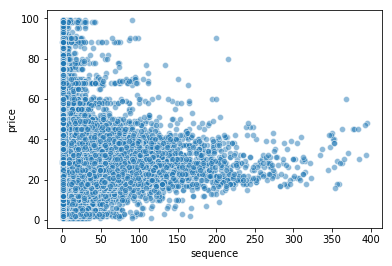

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

ax = sns.scatterplot(x="sequence", y="price", data=df_dish, alpha = 0.5)

In [ ]:
'volume', 'is_recommend', 'is_staple', 
                            'has_staple', 'staple_num', 'staple_price', 'old_package', 'type',
                            'taste', 'eat_num', 'is_del', 'tmr_only', 'set_meal', 'sequence', 'source'

In [84]:
df = df_dish.drop(columns =['stock', 'tomorrow_stock', 'daily_stock', 'staple_type'], axis=1).fillna(0)

# tokenize the names of the dishes
start = time.time()
df['name'] = df['name'].apply(tokenize)
print('used {:0.2f} seconds to tokenize the names'.format(time.time() - start))

# split the dataframe into training and testing
train, test = train_test_split(df, test_size=0.2, random_state=0)

# build vocab using the dish names in train
names = list(train['name'])
vocab = build_vocab(names, min_freq=5)

# get the summation of price for all tokens
start = time.time()
price = build_price_dict(train, vocab)
print('used {:0.2f} seconds to get tokens prices'.format(time.time() - start))

# build reference dataframe
df_outcome = pd.DataFrame({'name':list(vocab.keys()), 'count': list(vocab.values()), 'price_sum':list(price.values())})
df_outcome['mean_price'] = df_outcome['price_sum'] / df_outcome['count']

token_price_dict = dict(zip(df_outcome.name, df_outcome.mean_price))
m = train.price.median()

train['tokens_mean'] = train['name'].apply(lambda x: (get_price(x, token_price_dict)))
test['tokens_mean'] = test['name'].apply(lambda x: (get_price(x, token_price_dict)))
test['tokens_mean'].fillna('')

# adding kitchen_mean, dish_mean
df_price = kitchen_median(train)
#     df_dish_price = dish_median(train)
# df_dish_price = df_outcome[['kithen_id', 'mean_price']]

X_train = pd.merge(train, df_price, on='kitchen_id', how='left')
# X_train = pd.merge(X_train, df_dish_price, on='name', how='left')

X_train = X_train.drop(['kitchen_id'], axis=1)
X_train = X_train.drop(['name'], axis=1)

#     X_train.head()

X_train['kitchen_median'].fillna(m, inplace=True)
# adding kitchen_mean

X_train = X_train.drop(['price'], axis=1)

y_train = train['price']

# adding kitchen_mean
X_test = pd.merge(test, df_price, on='kitchen_id', how='left')
# X_test = pd.merge(X_test, df_dish_price, on='name', how='left')
X_test = X_test.drop(['kitchen_id'], axis=1)
X_test = X_test.drop(['name'], axis=1)

X_test['kitchen_median'].fillna(m, inplace=True)
# adding kitchen_mean

X_test = X_test.drop(['price'], axis=1)

y_test = test['price'] 
print('Train size: {}'.format(len(X_train)))
print('Test size: {}'.format(len(X_test)))

used 49.83 seconds to tokenize the names
used 25.07 seconds to get tokens prices
Train size: 304032
Test size: 76009


In [85]:
fit_model(X_train,y_train, X_test, y_test)

Fitting model..
Took 76.27 seconds to train the model
in-sample evaluation:('RMSE:6.479373572462514', 'MAE:3.947203007091307', 'R-square:0.6033478443592705')

out-sample evaluation:('RMSE:6.487331727755425', 'MAE:4.024381565222986', 'R-square:0.605161426638518')


In [91]:
from xgboost import XGBRegressor

my_model = XGBRegressor(max_depth=6, n_estimators=300, learning_rate=0.05)
my_model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=6, min_child_weight=1, missing=None, n_estimators=300,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [92]:
predictions = my_model.predict(X_test)

In [93]:
mse = mean_squared_error(predictions, y_test)
rmse = np.sqrt(mse)

In [94]:
print(rmse)

7.040983629472678
